<a href="https://colab.research.google.com/github/sasansharifipour/Spark_Class/blob/main/train_sheypoor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
file_download_link = "https://drive.google.com/u/0/uc?id=1K2a4mliN8l4aO1S8TWyn29EN25Y4WLlQ&export=download" 
!wget -O data.csv --no-check-certificate "$file_download_link"

--2021-05-22 11:19:06--  https://drive.google.com/u/0/uc?id=1K2a4mliN8l4aO1S8TWyn29EN25Y4WLlQ&export=download
Resolving drive.google.com (drive.google.com)... 142.250.101.101, 142.250.101.113, 142.250.101.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.101.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c16t2enu1sfe9hm4ge9l4tsrtr8juj1t/1621682325000/14577798666193718332/*/1K2a4mliN8l4aO1S8TWyn29EN25Y4WLlQ?e=download [following]
--2021-05-22 11:19:07--  https://doc-0g-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c16t2enu1sfe9hm4ge9l4tsrtr8juj1t/1621682325000/14577798666193718332/*/1K2a4mliN8l4aO1S8TWyn29EN25Y4WLlQ?e=download
Resolving doc-0g-70-docs.googleusercontent.com (doc-0g-70-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-0g-70-docs.googleusercontent.co

In [2]:
import pandas as pd

data = pd.read_csv('data.csv')

df = pd.DataFrame(data)

In [3]:
df.head()

,Unnamed: 0,userid,time,source,adstatus,item,count_views
0,0,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,Chrome,۳ روز پیش,A,1
1,1,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,Chrome,۴ روز پیش,A,1
2,2,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,Android,۲ روز پیش,B,1
3,3,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,Android,۶ روز پیش,B,1
4,4,1337524499886/ad464731-6288-4e04-8a1a-aa9c004f...,2021-05-03 05:00:00.000,Android,ساعاتی پیش,A,1


In [4]:
import networkx as nx

def create_graph(data):
  graph = nx.Graph()

  for index, row in data.iterrows():
    source_node = row["userid"]
    destination_node = str(row["adstatus"]) + "_" + str(row["item"])
    prior_weight = row["count_views"]

    graph.add_node(source_node, node_type='user')
    graph.add_node(destination_node, node_type='item')

    node_attributes = graph.get_edge_data(source_node, destination_node)

    if (node_attributes is not None):
      prior_weight = prior_weight + node_attributes["weight"]

    graph.add_weighted_edges_from([(destination_node, source_node,  prior_weight)])

  return graph


graph = create_graph(df)

In [5]:
page_ranks = nx.pagerank(graph, weight ='weight', max_iter =1000, alpha=0.9)

In [6]:
user_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "user"})
item_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "item"})
page_ranks.get(user_nodes[0])

3.838561778219871e-06

In [27]:
def extract_features(graph, page_ranks):
  user_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "user"})
  item_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "item"})

  column_names = item_nodes.copy()
  column_names.insert(0, 'user_rank')
  column_names.insert(0, 'user_id')

  data = []

  for user in user_nodes :
    user_rank = page_ranks.get(user)
    row_data = [user, user_rank]

    for item in item_nodes :
      item_rank = page_ranks.get(item)

      node_weight = 0
      node_attributes = graph.get_edge_data(user, item)
      
      if (node_attributes is not None):
        node_weight = node_attributes["weight"]
        
      calculated_feature = 1 * user_rank * item_rank
      row_data.append(calculated_feature)
    
    data.append(row_data)
  
  df = pd.DataFrame(data, columns = column_names)
  return df

In [28]:
df_features = extract_features(graph, page_ranks)

In [29]:
df_features.head(10)

,user_id,user_rank,ساعاتی پیش_C,۱ روز پیش_A,۶ ماه پیش_B,۴ روز پیش_A,۱ هفته پیش_C,۳ هفته پیش_C,لحظاتی پیش_C,۴ هفته پیش_B,۳ روز پیش_A,۲ روز پیش_A,۲ هفته پیش_A,ساعاتی پیش_B,۱ هفته پیش_B,۵ ماه پیش_C,۳ روز پیش_C,۱ روز پیش_C,۱ ماه پیش_B,۹ ماه پیش_B,۱ سال پیش_C,۱۰ ماه پیش_B,لحظاتی پیش_A,۱ ماه پیش_C,۲ ماه پیش_B,۵ ماه پیش_B,۶ روز پیش_B,۸ ماه پیش_C,دقایقی پیش_B,۵ روز پیش_A,۱ هفته پیش_A,۳ هفته پیش_B,۶ روز پیش_A,۲ ماه پیش_C,۱۱ ماه پیش_B,۷ ماه پیش_C,۷ ماه پیش_B,۶ روز پیش_C,۳ ماه پیش_B,۴ ماه پیش_C,دقایقی پیش_C,۲ روز پیش_C,۴ روز پیش_B,۴ هفته پیش_A,لحظاتی پیش_B,۱ سال پیش_B,۴ هفته پیش_C,۹ ماه پیش_C,۳ ماه پیش_A,دقایقی پیش_A,۴ ماه پیش_A,۸ ماه پیش_B,۴ روز پیش_C,ساعاتی پیش_A,۳ ماه پیش_C,۲ هفته پیش_B,۱ سال پیش_A,۱ ماه پیش_A,۵ روز پیش_B,۳ هفته پیش_A,۲ روز پیش_B,۶ ماه پیش_C,۳ روز پیش_B,۱ روز پیش_B,۲ هفته پیش_C,۵ روز پیش_C,۴ ماه پیش_B,۲ ماه پیش_A
0,1620032121394/12855882-f4d7-4574-89e4-83f3a2e5...,0.000004,6.081248e-08,1.249404e-07,7.193255e-10,3.306664e-08,1.898452e-08,1.002016e-08,1.943481e-08,1.148523e-08,4.368110e-08,6.548961e-08,5.119391e-08,1.160175e-07,7.691924e-08,1.822351e-10,6.396290e-09,1.659052e-08,8.610323e-09,3.843717e-10,1.320086e-11,5.172989e-10,8.550924e-08,6.048610e-09,5.207652e-09,1.280825e-09,1.629987e-08,4.312113e-11,1.622966e-08,2.652244e-08,8.648529e-08,4.293180e-08,2.094458e-08,4.459275e-09,4.971322e-10,1.926633e-09,1.970218e-09,3.775512e-09,3.295335e-09,4.862927e-10,1.544528e-08,9.925573e-09,2.159035e-08,7.995839e-09,1.424745e-08,3.314685e-09,2.529777e-09,2.969782e-11,1.306852e-11,8.594537e-08,1.110813e-11,3.847884e-10,5.474864e-09,4.706566e-07,4.367279e-10,5.176552e-08,1.119135e-11,5.095625e-10,1.924286e-08,3.283621e-08,3.532855e-08,1.455499e-10,2.537279e-08,5.060351e-08,1.292528e-08,4.666264e-09,3.003665e-09,1.363180e-10
1,1620055581050/323a7135-e206-4a0d-9c54-27f88f2c...,0.000003,4.602136e-08,9.455176e-08,5.443675e-10,2.502401e-08,1.436701e-08,7.583004e-09,1.470777e-08,8.691730e-09,3.305676e-08,4.956090e-08,3.874227e-08,8.779912e-08,5.821055e-08,1.379109e-10,4.840551e-09,1.255529e-08,6.516076e-09,2.908829e-10,9.990079e-12,3.914789e-10,6.471125e-08,4.577436e-09,3.941020e-09,9.692965e-10,1.233533e-08,3.263299e-11,1.228220e-08,2.007152e-08,6.544989e-08,3.248971e-08,1.585033e-08,3.374668e-09,3.762172e-10,1.458028e-09,1.491012e-09,2.857212e-09,2.493827e-09,3.680141e-10,1.168860e-08,7.511425e-09,1.633903e-08,6.051050e-09,1.078211e-08,2.508470e-09,1.914472e-09,2.247457e-11,9.889927e-12,6.504130e-08,8.406356e-12,2.911982e-10,4.143240e-09,3.561811e-07,3.305047e-10,3.917484e-08,8.469331e-12,3.856241e-10,1.456251e-08,2.484962e-08,2.673576e-08,1.101485e-10,1.920149e-08,3.829547e-08,9.781527e-09,3.531312e-09,2.273098e-09,1.031620e-10
2,1618305496872/ef33b880-f26a-4f79-815d-ddd161d1...,0.000005,7.740704e-08,1.590342e-07,9.156156e-10,4.208989e-08,2.416503e-08,1.275447e-08,2.473819e-08,1.461932e-08,5.560083e-08,8.336047e-08,6.516374e-08,1.476764e-07,9.790903e-08,2.319635e-10,8.141714e-09,2.111776e-08,1.095991e-08,4.892593e-10,1.680312e-11,6.584599e-10,1.088431e-07,7.699159e-09,6.628720e-09,1.630338e-09,2.074779e-08,5.488806e-11,2.065843e-08,3.375991e-08,1.100855e-07,5.464707e-08,2.665995e-08,5.676126e-09,6.327901e-10,2.452375e-09,2.507853e-09,4.805776e-09,4.194569e-09,6.189927e-10,1.966000e-08,1.263407e-08,2.748194e-08,1.017775e-08,1.813530e-08,4.219199e-09,3.220104e-09,3.780179e-11,1.663467e-11,1.093982e-07,1.413933e-11,4.897897e-10,6.968850e-09,5.990897e-07,5.559026e-10,6.589133e-08,1.424525e-11,6.486123e-10,2.449386e-08,4.179658e-08,4.496903e-08,1.852677e-10,3.229654e-08,6.441224e-08,1.645234e-08,5.939598e-09,3.823307e-09,1.735165e-10
3,1619867213109/59da4193-ca06-41cb-9b82-b6166c0d...,0.000008,1.344792e-07,2.762902e-07,1.590699e-09,7.312277e-08,4.198191e-08,2.215833e-08,4.297766e-08,2.539815e-08,9.659531e-08,1.448221e-07,1.132090e-07,2.565582e-07,1.700973e-07,4.029902e-10,1.414460e-08,3.668788e-08,1.904066e-08,8.499902e-10,2.919206e-11,1.143942e-09,1.890931e-07,1.337575e-08,1.151607e-08,2.832386e-09,3.604513e-08,9.535701e-11,3.588988e-

In [30]:
from sklearn import preprocessing

df_without_user_id = df_features.iloc[:, 1::].to_numpy()

min_max_scaler = preprocessing.MinMaxScaler()
df_without_user_id_scaled = min_max_scaler.fit_transform(df_without_user_id)

df_scaled = pd.DataFrame(df_without_user_id_scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66
0,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914,0.000914
1,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
2,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828,0.001828
3,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975
4,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823


In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

pca.fit(df_without_user_id_scaled)
pca_data = pca.transform(df_without_user_id_scaled)

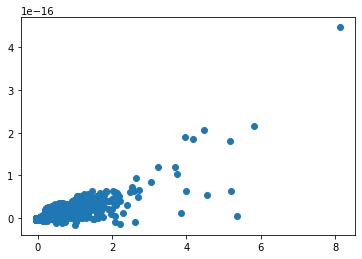

In [38]:
import matplotlib.pyplot as plt

plt.scatter(pca_data[:,0], pca_data[:,2])
plt.show()

In [22]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, init='k-means++', random_state=0).fit(df_without_user_id)

In [23]:
lst = list(kmeans.labels_)
for i in range(30):
  print(str(i) + ":" + str(lst.count(i)))

0:49616
1:2
2:15
3:1
4:37
5:15
6:379
7:2
8:2
9:3
10:34
11:1573
12:4
13:1
14:76
15:148
16:1
17:4
18:1
19:3
20:0
21:0
22:0
23:0
24:0
25:0
26:0
27:0
28:0
29:0


In [ ]:
df["adstatus"].value_counts()

ساعاتی پیش    48208
۱ روز پیش     18756
۱ هفته پیش    15165
دقایقی پیش    13422
لحظاتی پیش    12156
۲ روز پیش     11864
۲ هفته پیش    10335
۳ روز پیش      8621
۳ هفته پیش     7908
۴ روز پیش      6951
۵ روز پیش      5864
۶ روز پیش      4939
۴ هفته پیش     2446
۱ ماه پیش      1104
۲ ماه پیش       688
۷ ماه پیش       264
۳ ماه پیش       232
۴ ماه پیش       202
۱ سال پیش       172
۵ ماه پیش        84
۶ ماه پیش        38
۱۱ ماه پیش       25
۱۰ ماه پیش       24
۸ ماه پیش        24
۹ ماه پیش        23
Name: adstatus, dtype: int64

In [ ]:
pd.get_dummies(df, columns=["item","adstatus", "source"]).head()

,Unnamed: 0,userid,time,count_views,item_A,item_B,item_C,adstatus_دقایقی پیش,adstatus_ساعاتی پیش,adstatus_لحظاتی پیش,adstatus_۱ روز پیش,adstatus_۱ سال پیش,adstatus_۱ ماه پیش,adstatus_۱ هفته پیش,adstatus_۱۰ ماه پیش,adstatus_۱۱ ماه پیش,adstatus_۲ روز پیش,adstatus_۲ ماه پیش,adstatus_۲ هفته پیش,adstatus_۳ روز پیش,adstatus_۳ ماه پیش,adstatus_۳ هفته پیش,adstatus_۴ روز پیش,adstatus_۴ ماه پیش,adstatus_۴ هفته پیش,adstatus_۵ روز پیش,adstatus_۵ ماه پیش,adstatus_۶ روز پیش,adstatus_۶ ماه پیش,adstatus_۷ ماه پیش,adstatus_۸ ماه پیش,adstatus_۹ ماه پیش,source_Android,source_Chrome
0,0,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,2,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,4,1337524499886/ad464731-6288-4e04-8a1a-aa9c004f...,2021-05-03 05:00:00.000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
